<a href="https://colab.research.google.com/github/daorhe2272/analisis_de_datos_I/blob/main/Proyecto_Final_Analisis_Datos_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introducción**

**Problema estudiado:** ventas no realizadas por inventario insuficiente en una empresa con altos volúmenes de rotación.

**Pregunta SMART:** ¿Cómo puedo predecir con precisión la demanda por producto mes a mes, sin manejar inventarios excesivamente altos, en una empresa de distribución de productos de consumo masivo que maneja un catálogo de más de 7.000 artículos?

Intentaremos dar respuesta a esta pregunta, ya que es posible responderla por medio de la técnica de forecasting (pronóstico), teniendo en cuenta que la empresa cuenta con un ERP que conserva datos referentes a la rotación por producto por varios meses.

# **Extracción de los datos**

In [361]:
import pandas as pd
import numpy as np

Nuestra base de datos girará alrededor del catálogo de productos de la empresa. Éstos provienen de dos fuentes. La primera contiene información relevante sobre cada producto como su última fecha de compra, el tipo de producto, descripciones completas, etc. La segunda contiene información cuantitativa de ventas con un rango de 16 meses. Nota importante: estos datos son reales, por lo que deben ser tratados con prudencia.

In [417]:
file_A = "https://raw.githubusercontent.com/daorhe2272/analisis_de_datos_I/main/query_results.json"
file_B = "https://raw.githubusercontent.com/daorhe2272/analisis_de_datos_I/main/ESTRES02"

df_A = pd.read_json(file_A)

# Se eliminan algunas columnas irrelevantes
columns_to_drop = ["Activo","Marca","Costo","Rotacion_actual","Comprado","iva","Stock","Unidad_venta","Rotacion_mes","Rotacion_bimestre","Rotacion_trimestre"]
df_A = df_A.drop(columns=columns_to_drop)

# La segunda fuente de datos viene en formato de separaciones fijas (fixed width file)
# por lo que debe especificarse el ancho de cada columna
col_widths = [6,19,46,8,8,8,8,8,8,8,40,8,8,8,8,8,8,8,8,8,8,8,8]
df_B = pd.read_fwf(file_B, widths=col_widths)

# Se detectan algunos valores duplicados en los datos de la segunda fuente
df_B = df_B.drop_duplicates(subset='Cod_barras')

# Se eligen las columnas a conservar
columns_B = df_B[["Cod_barras", "Var_Y", '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']]

# Hacemos un JOIN entre las dos diferentes fuentes de datos
df = pd.merge(df_A, columns_B, left_on='Codigo', right_on='Cod_barras', how='inner')

In [368]:
# Al final del ejercicio tenemos una buena cantidad de registros
df.shape

(8482, 25)

In [369]:
# Revisamos que la unión de los datos haya sido exitosa:
df.head()

,Categorias,_id,Codigo,Descripcion,Precio_base,Fecha_compra,Descripcion_full,Cod_barras,Var_Y,2024-01,...,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
0,"[Papel regalos, seda, crepé, craft]",63e570ea6aa0ed10c8a8340b,1375,PAPEL CELOFAN AMARILLO 96X100,440,20231204,Papel celofan amarillo 96x099,1375,130,20,...,0,0,0,30,120,180,370,250,1050,1800
1,[Otros cacharrería],63e570ea6aa0ed10c8a833e3,1003,INGRESO PARA TERCEROS (22937),1380000,20200210,Ingreso para terceros,1003,0,0,...,0,0,3,5,2,2,0,0,0,0
2,[Cuadernos y agendas],63e570ea6aa0ed10c8a833ed,7861084254023,CUAD.LINEA AZUL 85-100-1 STIKER,1800,20190215,Cuaderno Línea Azul con stickers argollado peq...,7861084254023,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[Bombillos],63e570ea6aa0ed10c8a83467,7703255298989,BOMBILLO NALPILUX LED 5W,2800,20240822,Bombillo Nalpilux led 5w,7703255298989,100,121,...,77,33,69,173,50,72,127,60,142,113
4,[Enjuages bucales],63e570ea6aa0ed10c8a83487,037000956662,ENJ.CREST SCOPE OUTLAST X500ML,11520,20230118,Enjuague bucal crest scope outlast de 500 ml,037000956662,0,0,...,0,0,0,0,0,0,0,0,0,0


Estas son nuestras variables iniciales:

* _id: Un valor de identificación que nos servirá para identificar con precisión cada producto del set de datos.
* Categorias: un listado que define la tipología del producto (ej: bebidas nutricionales, cuadernos, lapiceros). Un producto puede tener más de una categoría, o así mismo puede no tenerla. Esto depende de la información con la que fue codificado inicialmente.
* Codigo: corresponde al código de barras del producto.
* Descripción: el nombre del producto tal como aparece en facturación.
* Precio_base: el precio de venta en el futuro. Podría o no ser una variable relevante al momento de hacer el análisis exploratorio.
* Fecha de compra: la última fecha en la que se compró el producto. Puede ser útil para filtrar productos de acuerdo a necesidades específicas.
* Var_Y: corresponde a las ventas de julio del 2024. Usaremos esta variable como una guía para evaluar la efectividad de los modelos empleados.
* Variables temporales: contiene información de ventas para cada producto en el mes indicado.

# **Limpieza y transformación de los datos**

In [370]:
# Total de meses de los que tenemos datos
total_months = ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']

# Los últimos 12 meses anteriores con respecto a la variable dependiente Y
months = ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']

Por diversas razones, es muy común que hayan vacíos en la rotación de cada producto. Pueden haber una ruptura de inventario por falta de materia prima por parte del fabricante, un cambio de código de barras, un cambio de imagen, el producto puede ser descontinuado, etc.

En este caso, definimos que un producto con demasiados vacíos en sus datos de rotación es aquel que registra 5 o más meses sin ventas. Es muy posible que estos productos se hayan descontinuado, o bien son muy nuevos y no hay suficiente información para conocer su rotación real. Por lo tanto los eliminamos de nuestro set de datos.

In [ ]:
# Contamos el número de meses sin rotación por producto
df['zero_count'] = (df[months] == 0).sum(axis=1)

# Conservamos las filas de productos con al menos 8 meses de datos de ventas
df = df[df['zero_count'] < 5].drop('zero_count', axis=1)

In [371]:
# Quedamos aún con una buena cantidad de registros
df.shape

(4016, 25)

In [372]:
# Revisamos que no hayan valores nulos:
df.isnull().sum()

,0
Categorias,0
_id,0
Codigo,0
Descripcion,0
Precio_base,0
Fecha_compra,0
Descripcion_full,0
Cod_barras,0
Var_Y,0
2024-01,0


Como se mencionó más arriba, un producto puede no registrar rotación por muchas razones, lo cuál distorciona nuestra habilidad para hacer predicciones. Es por esta razón que vamos a imputar los valores y llenar estos vacíos con el valor promedio de ventas.
Python dispone de herramientas para imputar valores faltantes por la media, pero en este caso, por las características y el contexto de los datos, vamos a calcular el promedio de ventas sin tener en cuenta los meses sin rotación. Esto nos obliga a aplicar manualmente los cambios.

In [373]:
# Convertimos los ceros a NaN
df[total_months] = df[total_months].replace(0, np.nan)

# Calculamos la media para cada fila (de los últimos 12 meses)
row_means = df[months].mean(axis=1)
df["Medias"] = row_means

# Llenamos los NaN con la media
df[total_months] = df[total_months].apply(lambda row: row.fillna(row_means[row.name]), axis=1)

Para realizar comparaciones entre productos o alimentar modelos de series de tiempo, resulta útil normalizar nuestros datos de ventas. En este caso vamos a aplicar una normalización por la media.

In [374]:
# Calculamos la media para cada producto:
row_mean = df[months].mean(axis=1)

# Dividimos las ventas de cada producto por sus ventas promedio anuales:
df[total_months] = df[total_months].divide(row_mean, axis=0)

In [375]:
# Revisamos los cambios:
df.describe()

,Precio_base,Fecha_compra,Var_Y,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,Medias
count,4016.000000,4.016000e+03,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000
mean,11263.209661,2.023767e+07,91.010956,1.152791,0.977472,0.797257,1.020389,0.934691,0.850498,1.145800,0.990157,1.102827,1.080669,1.079049,1.164998,0.960934,1.025561,1.040070,0.996290,103.159027
std,18700.811215,9.200412e+03,433.160402,0.890504,0.627466,0.539439,0.644918,0.609290,0.547242,1.289932,0.820503,0.850938,0.926131,0.742391,0.744664,0.606059,0.675772,0.701146,0.644828,386.841434
min,50.000000,2.004030e+07,0.000000,0.002233,0.004307,0.002850,0.007859,0.006822,0.001151,0.003394,0.005658,0.004488,0.001358,0.007473,0.006294,0.009009,0.009144,0.006555,0.006742,1.000000
25%,2900.000000,2.024021e+07,3.000000,0.600000,0.545455,0.406608,0.609511,0.530018,0.466266,0.690399,0.564379,0.647004,0.625713,0.636609,0.695281,0.541621,0.591401,0.580615,0.541336,7.300000
50%,6675.000000,2.024063e+07,12.000000,1.000000,0.916667,0.738215,0.979592,0.908934,0.823193,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913867,0.956522,0.987707,0.947368,19.087121
75%,13950.000000,2.024082e+07,47.000000,1.419355,1.226323,1.000000,1.276744,1.154998,1.017638,1.238253,1.074471,1.290323,1.250000,1.333333,1.440000,1.204443,1.259400,1.299644,1.288416,58.240530
max,595000.000000,2.024090e+07,15981.000000,8.237258,6.426136,6.402062,7.439421,9.088235,5.921053,43.361702,20.725084,15.536424,24.375000,10.541120,7.895223,5.894737,7.632551,6.976744,6.870662,7762.000000


Es normal que hayan fluctuaciones en las ventas de un producto. En ocasiones, estos valores pueden ser muy extremos; por ejemplo si hay una venta a una institución del gobierno a través de una licitación. En estos casos, los valores extremos pueden generar predicciones desfazadas. Para reducir la influencia de estos valores, vamos a usar la técnica de imputación Z-score y vamos a limitarlos a 3 desviaciones estándar.

In [376]:
from scipy import stats

# Calculamos los valores Z para cada fila:
z_scores = stats.zscore(df[months], axis=1)

# Definimos valores mínimos y máximos:
lower_bound = df[months].mean(axis=1) - 3 * df[months].std(axis=1)
upper_bound = df[months].mean(axis=1) + 3 * df[months].std(axis=1)

# Recortamos los valores extremos:
df[months] = df[months].clip(lower=lower_bound, upper=upper_bound, axis=0)

No se aprecian cambios dramáticos en las valores máximos y mínimos de ventas, lo cual puede indicar que, en general, los datos son robustos y confiables.

In [377]:
df.describe()

,Precio_base,Fecha_compra,Var_Y,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,Medias
count,4016.000000,4.016000e+03,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000,4016.000000
mean,11263.209661,2.023767e+07,91.010956,1.151952,0.977403,0.797246,1.019958,0.934462,0.850395,1.145800,0.990157,1.102827,1.080669,1.078419,1.164677,0.960802,1.025206,1.039715,0.996146,103.159027
std,18700.811215,9.200412e+03,433.160402,0.886064,0.626985,0.539368,0.641307,0.606793,0.546418,1.289932,0.820503,0.850938,0.926131,0.736399,0.742421,0.605159,0.672882,0.698777,0.643861,386.841434
min,50.000000,2.004030e+07,0.000000,0.002233,0.004307,0.002850,0.007859,0.006822,0.001151,0.003394,0.005658,0.004488,0.001358,0.007473,0.006294,0.009009,0.009144,0.006555,0.006742,1.000000
25%,2900.000000,2.024021e+07,3.000000,0.600000,0.545455,0.406608,0.609511,0.530018,0.466266,0.690399,0.564379,0.647004,0.625713,0.636609,0.695281,0.541621,0.591401,0.580615,0.541336,7.300000
50%,6675.000000,2.024063e+07,12.000000,1.000000,0.916667,0.738215,0.979592,0.908934,0.823193,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.913867,0.956522,0.987707,0.947368,19.087121
75%,13950.000000,2.024082e+07,47.000000,1.419355,1.226323,1.000000,1.276744,1.154998,1.017638,1.238253,1.074471,1.290323,1.250000,1.333333,1.440000,1.204443,1.259400,1.299644,1.288416,58.240530
max,595000.000000,2.024090e+07,15981.000000,7.949392,6.426136,6.402062,7.167169,8.651397,5.740071,43.361702,20.725084,15.536424,24.375000,10.051843,7.745533,5.762609,7.297327,6.707223,6.749731,7762.000000


In [378]:
# Recordemos que un producto puede tener más de una categoría.
# Usamos la función explode para desestructurar las filas de artículos con más de una categoría
df = df.explode("Categorias")

In [379]:
# Esto nos genera algunos duplicados, los cuales es mejor eliminar para el modelado de los datos
df = df.drop_duplicates(subset="_id",keep="first")

In [380]:
# Verificamos que ahora las Categorias son strings y no listas:
df[["Descripcion","Categorias"]]

,Descripcion,Categorias
0,PAPEL CELOFAN AMARILLO 96X100,"Papel regalos, seda, crepé, craft"
3,BOMBILLO NALPILUX LED 5W,Bombillos
6,DST.ELIZAB.CREM.X135G.X2 P/ESP.,Deshodorantes
9,BLOQ.NUDE SPF 50 X50ML FAC.COLOR,Protección solar
11,BLOQ.NUDE SPF50 X12UN.X10ML.COLOR.FAC.,Protección solar
...,...,...
7528,PAPEL FOTOG.AH ROYAL 200GR.X 20H 216X279,NaN
7529,TARRITO ROJO JGB X330 TRAD.+CR.X22,Bebidas nutricionales
7532,PAPEL H.ROSAL XXG X3ROLL.X30M.C/U,Papel higiénico
7540,CARPETA PRIMAV.LIGA PLAS.PAST.324-052,Carpetas y legajadores


In [381]:
# Recordemos que hay productos que no tienen categoría
# Descartamos las filas de productos sin una categoría
# Asumimos que los valores faltantes son MCAR

df = df.dropna(subset=['Categorias'])

In [382]:
# Verificamos rápidamente que no hayan quedado filas de productos sin su respectiva categoría
df["Categorias"].isna().sum() == 0

True

In [383]:
# Revisamos que el tipo de datos se adapte a nuestras necesidades
df.dtypes

,0
Categorias,object
_id,object
Codigo,object
Descripcion,object
Precio_base,int64
Fecha_compra,int64
Descripcion_full,object
Cod_barras,object
Var_Y,int64
2024-01,float64


# **Exploración inicial de los datos**

Para usar efectivamente las librerías de gráficación, y también para el modelado de los datos más adelante, es necesario convertir las columnas de cada mes de ventas en una sola columna verticalizada.

In [384]:
df = pd.melt(
    df,
    id_vars=['Categorias', '_id', 'Descripcion', 'Precio_base', 'Var_Y', 'Descripcion_full', 'Medias'],
    value_vars=total_months,
    var_name='Mes',
    value_name='Ventas'
)

Gracias a este cambio, hemos reducido el número de columnas significativamente, aunque ahora hay muchas más filas de datos:

In [385]:
df.shape

(63552, 9)

In [386]:
import matplotlib.pyplot as plt
import seaborn as sns

Ahora hemos hecho una limpieza completa de los datos, podemos entrar a analizar el comportamiento de las variables de interés. La siguiente gráfica nos muestra la evolución de las ventas de 10 productos de nuestro data set a través de los meses. El comportamiento de uno y otro producto varía bastante, lo que sugiere que existen señales que podrían ser capturadas si contamos con las variables explicativas adecuadas.

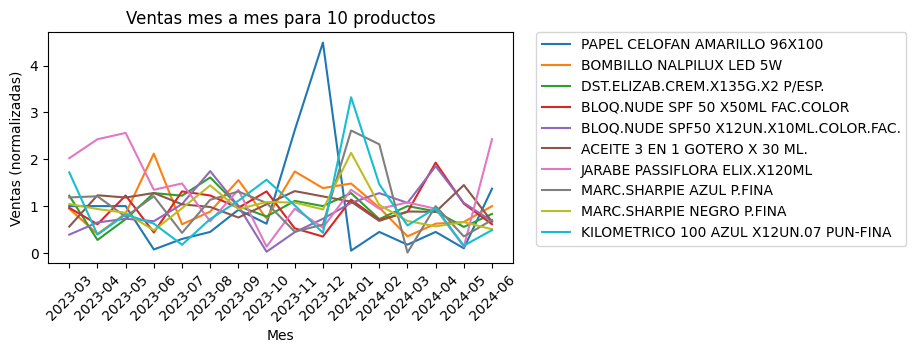

In [387]:
# Graficamos la evolución de las ventas de 10 productos del dataset
products = df['_id'].unique()[:10]
data = df[df["_id"].isin(products)]

data = data.sort_values('Mes')

plt.figure(figsize=(6, 3))
for product in products:
    product_data = data[data["_id"] == product]
    plt.plot(product_data['Mes'], product_data['Ventas'], label=product_data['Descripcion'].iloc[0])

plt.title("Ventas mes a mes para 10 productos")
plt.xlabel('Mes')
plt.ylabel("Ventas (normalizadas)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()


Hacemos el mismo análisis, esta vez agrupando los productos por categoría. Si bien la variabilidad se reduce un poco, podemos ver que el comportamiento no obedece a un comportamiento general del consumo, sino que cada categoría tiene su propia evolución.

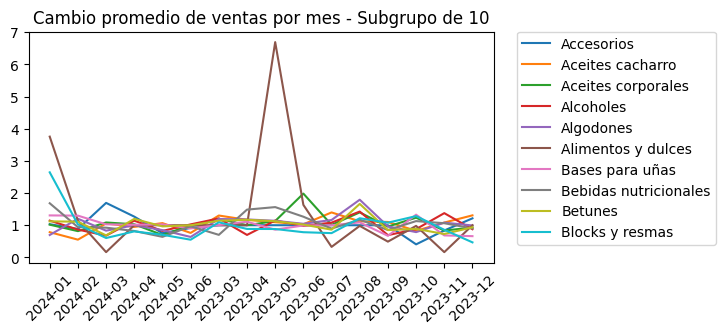

In [388]:
# grupamos los datos de acuerdo a la media de ventas por mes de cada categoría:
grupos = df.groupby(['Categorias', 'Mes'])['Ventas'].mean().reset_index()

# Definimos el orden de los meses
grupos['Mes'] = pd.Categorical(grupos['Mes'], categories=total_months, ordered=True)

# Generamos un listado de categorías
categorias = grupos['Categorias'].unique()

# Seleccionamos una fracción de las categorías para graficarlas
subgrupo = categorias[0:10]

plt.figure(figsize=(6, 3))

for category in subgrupo:
  data = grupos[grupos['Categorias'] == category].sort_values('Mes')
  plt.plot(data['Mes'], data['Ventas'], label=category)

plt.title(f'Cambio promedio de ventas por mes - Subgrupo de 10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()

La hipótesis que se ha presentado con las anteriores gráficas toma mucha más fuerza al dibujar un mapa de calor con las correlaciones entre categorías de productos. Vemos que algunos productos tienen correlaciones negativas. Observamos, por ejemplo, que las ventas de bronceadores disminuye cuando la venta de productos escolares aumenta. Por otro lado, las ventas de productos escolares aumentan relativamente a otros productos escolares.

Idealmente, los modelos predictivos serán capaces de capturar la dirección y magnitud de estos cambios a través de los meses.

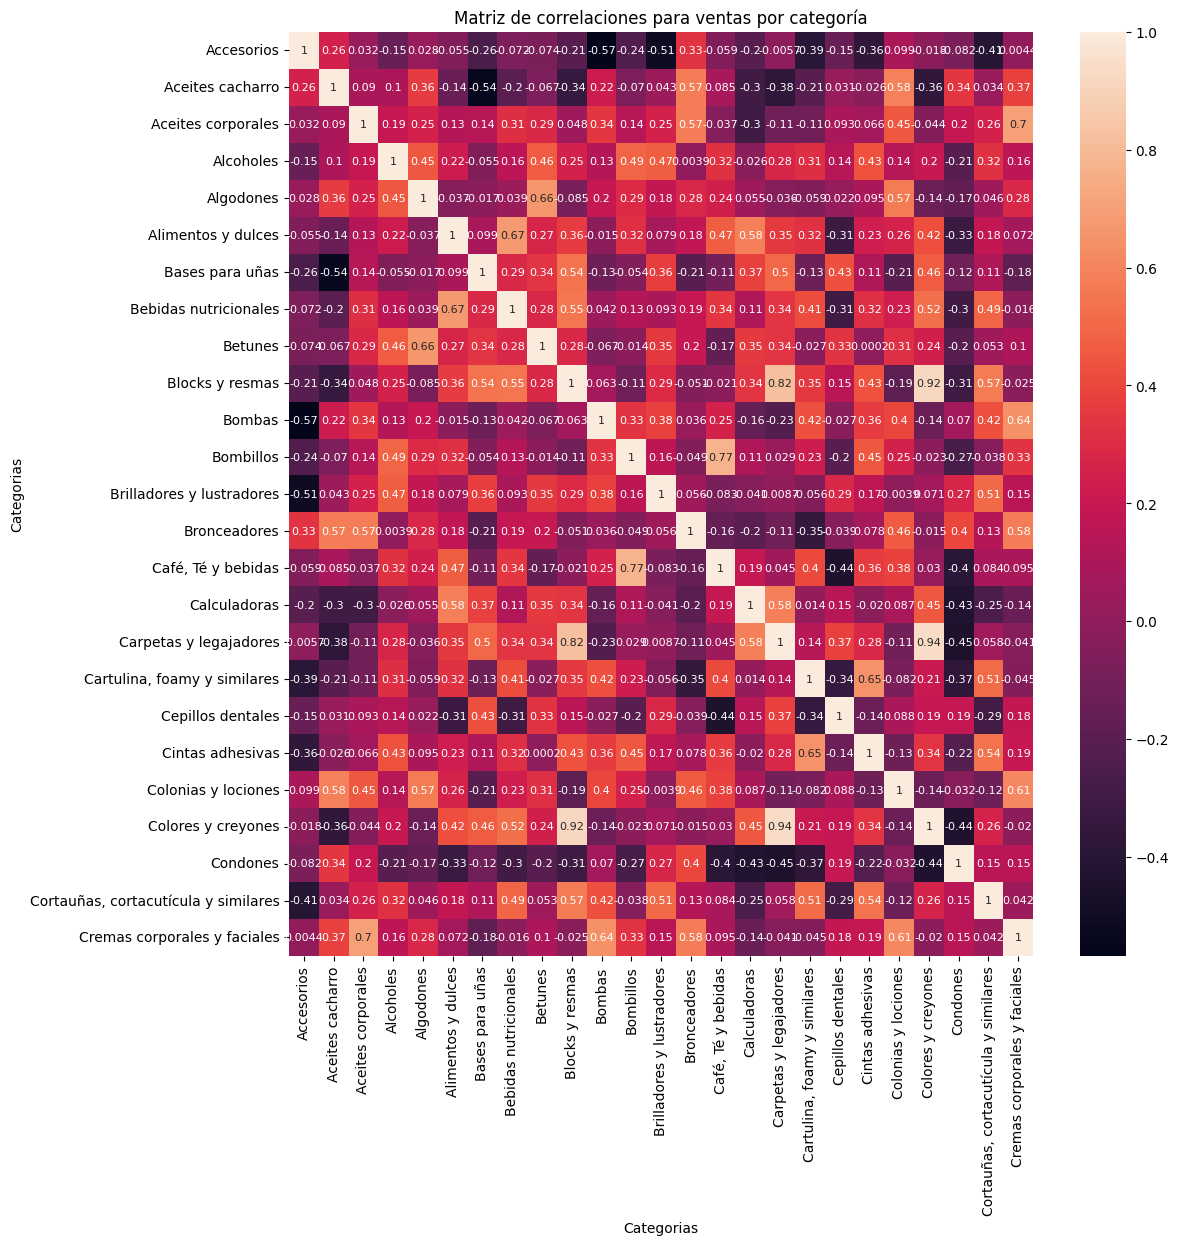

In [389]:
data = grupos[grupos["Categorias"].isin(categorias[:25])]

# Mapa de calor de la matriz de correlaciones
plt.figure(figsize=(12, 12))
df_pivot = data.pivot_table(index='Mes', columns='Categorias', values='Ventas')
correlation = df_pivot.corr()
sns.heatmap(correlation, annot=True, annot_kws={"size": 8})
plt.title('Matriz de correlaciones para ventas por categoría')
plt.show()

# **Feature Engineering**

A continuación preparamos el terreno para el modelado de series de tiempo creando variables afines a este tipo de análisis.

Las variables dummy son necesarias para convertir los datos categóricos en valores binarios que permitan capturar su influencia en una variable:

In [390]:
# Creamos variables dummy para cada categoría:
df = pd.get_dummies(df, columns=['Categorias'], drop_first=True)

Las variables de rezago son enormemente importantes para el análisis de series de tiempo. Estas representan una señal de "arrastre" capturada a través de los datos de mediciones anteriores. Para nuestro análisis, nos limitamos a una sola variable de rezago con 1 solo periodo de rezago.

In [391]:
# Creamos la variable de rezago:
df = df.sort_values(by=['_id', 'Mes'])
df["Rezago"] = df.groupby('_id')['Ventas'].shift(1)

Otro tipo de variable muy importante para el análisis de series de tiempo es la media móvil. Esta variable captura una señal más "suavizada" de las mediciones anteriores al promediar dichas mediciones en varios periodos. Para nuestro análisis, creamos una media móvil relativa a los 3 últimos meses de mediciones.

In [392]:
# Creamos una variable para la media móvil de 3 meses
df["Media_movil"] = df.groupby('_id')['Ventas'].rolling(3, min_periods=2).mean().reset_index(level=0, drop=True)
df[['Descripcion', 'Mes', 'Ventas', 'Rezago','Media_movil']].head(10)

,Descripcion,Mes,Ventas,Rezago,Media_movil
23954,PAPEL CELOFAN ROJO 96X100,2023-03,1.000000,NaN,NaN
27926,PAPEL CELOFAN ROJO 96X100,2023-04,1.000000,1.000000,1.000000
31898,PAPEL CELOFAN ROJO 96X100,2023-05,1.000000,1.000000,1.000000
35870,PAPEL CELOFAN ROJO 96X100,2023-06,0.097387,1.000000,0.699129
39842,PAPEL CELOFAN ROJO 96X100,2023-07,0.136342,0.097387,0.411243
43814,PAPEL CELOFAN ROJO 96X100,2023-08,0.720662,0.136342,0.318130
47786,PAPEL CELOFAN ROJO 96X100,2023-09,0.973868,0.720662,0.610291
51758,PAPEL CELOFAN ROJO 96X100,2023-10,0.623275,0.973868,0.772602
55730,PAPEL CELOFAN ROJO 96X100,2023-11,1.343938,0.623275,0.980360
59702,PAPEL CELOFAN ROJO 96X100,2023-12,5.851859,1.343938,2.606357


# **Modelado de los datos**

Para responder nuestra pregunta SMART vamos a utilizar dos modelos muy efectivos en el modelado de series de tiempo adecuados para nuestro análisis: el modelo ARIMA y el modelo de Random Forest.

## **Modelo ARIMA**

Este modelo captura las variaciones temporales en la variable objetivo a través de diferentes tipos de señales. Determina un componente autoregresivo (AR), otro integrado (I), y una media móvil (MA), los cuales explican los cambios en los datos a través de patrones repetitivos.

In [393]:
from statsmodels.tsa.arima.model import ARIMA

# Definimos un nuevo dataframe para este modelo:
df_ARIMA = df

# Usamos una fracción de los datos para evitar computaciones excesivas:
ids = df_ARIMA["_id"].unique()[:20]

In [396]:
# Reducimos el exceso de logs en la consola por las diversas advertencias que generan los modelos ARIMA:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [397]:
# Generamos un modelo para cada uno de los productos del rango seleccionado:
arima_models = {}

periods = len(df_ARIMA[df_ARIMA["_id"] == ids[0]])
for id in ids:
    dates = pd.date_range(start="2023-03",periods=periods,freq="M")
    # Obtenemos los datos de cada producto
    data = df_ARIMA[df_ARIMA['_id'] == id]
    data = data.set_index(dates)

    # Aplicamos el modelo a cada producto
    model = ARIMA(data['Ventas'], order=(1, 1, 1), freq="M")
    model_fit = model.fit()

    # Guardamos el modelo en un diccionario
    arima_models[id] = model_fit

In [398]:
# Generamos un listado para guardar los resultados:
pronosticos = []

# Guardamos los resultados en el listado:
for id, model_fit in arima_models.items():
    forecast = model_fit.forecast(steps=1)
    pronosticos.append({
        '_id': id,
        'Pronostico': forecast.iloc[0]
    })

# Convertimos los resultados a un dataframe:
pronosticos_ARIMA = pd.DataFrame(pronosticos)

In [399]:
# Combinamos los resultados obtenidos para vincularlos a su respectivo nombre de producto y variable dependiente:
pronosticos_ARIMA = pd.merge(pronosticos_ARIMA, df[['_id', 'Descripcion', 'Var_Y', 'Medias']], on="_id", how="left")

# Desnormalizamos los resultados para interpretarlos
pronosticos_ARIMA["Pronostico"] = (pronosticos_ARIMA["Pronostico"] * pronosticos_ARIMA["Medias"]).astype(int)
pronosticos_ARIMA.drop_duplicates().drop(columns=['Medias'])

,_id,Pronostico,Descripcion,Var_Y
0,63e570ea6aa0ed10c8a83403,487,PAPEL CELOFAN ROJO 96X100,140
16,63e570ea6aa0ed10c8a83405,475,PAPEL CELOFAN AZUL 96X100,180
32,63e570ea6aa0ed10c8a83407,102,FONDO PESEBRE GDE.,12
48,63e570ea6aa0ed10c8a8340b,430,PAPEL CELOFAN AMARILLO 96X100,130
64,63e570ea6aa0ed10c8a8340d,354,PAPEL CELOFAN TRANSP. 96X100,250
80,63e570ea6aa0ed10c8a83413,3,LAPIC.BIC ULT.FINO 07 x12+1 NEG.,3
96,63e570ea6aa0ed10c8a83415,3,LAPIC.BIC CRIST.ULT.F.FASH.07MMX12SUR,0
112,63e570ea6aa0ed10c8a83419,2,MAQ.BIC COMFORT 3 ADV.SENSIT.X12,3
128,63e570ea6aa0ed10c8a8341d,5,MAQ.BIC COMFORT 3 ADVANCE .X12,1
144,63e570ea6aa0ed10c8a8341f,12,LAPIC.BIC CRISTAL ROJO X12 UN.,15


**Conclusiones:** Recordemos que la variable Y corresponde a los valores que queríamos predecir (ventas de julio). Como podemos ver, el modelo ARIMA se desempeña bien en algunos casos, mientras que en otros falla. Específicamente, las predicciones se quedan cortas (o pasan de largo, en realidad) cuando el modelo intenta predecir las ventas de productos con altas varianzas estacionales. Entre más alta la varianza estacional de un producto, más sobreestima el valor Y. Esto es comprensible ya que en nuestro caso, la información de ventas está limitada a un máximo de 16 meses. Mi apreciación es que este tipo de regresiones con cambios estacionales dependen de datos completos para varios periodos (años en este caso) para capturar las variaciones con mayor fidelidad.

No obstante, en la práctica del comercio es muy difícil tener una disponibilidad de datos con ese alcance. Por ejemplo, durante la pandemia muchas empresas se vieron obligadas a cambiar la presentación de sus productos por otros de menor contenido. O por cambios de dirección en el Invima, muchas empresas se vieron obligadas a cambiar la formulación de sus productos. En ambos casos, el fabricante saca al mercado un producto que reemplaza el anterior, con precios y códigos de barra diferentes, por lo que se pierde el historial de ventas. Lo mismo sucede cuando un fabricante cambia de nombre (Johnson & Johnson ahora se llama Kenvue, por ejemplo), o cuando por estrategias de mercado cambia la imagen de un producto.

En otras palabras, no es óptimo en el contexto del comercio al por mayor y al detal usar modelos ARIMA o similares para la predicción de la demanda. Resulta evidente que un agente de compras y aprovisionamiento con suficiente experiencia en su trabajo puede predecir con mayor exactitud la demanda. Para ilustrar mi punto, un responsable de compras sabría que el papel celofán se vende más a final de año ya que este es utilizado para hacer anchetas, y lo mismo las pilas que son necesarias para el funcionamiento de los juguetes regalados en navidad. Los lapiceros, por otro lado, tienen mayores ventas a inicios de año cuando los colegios inician sus clases.

Como una observación final, quiero resaltar que, por lo menos bajo las condiciones de modelado de este proyecto, el gasto computacional de calcular un modelo ARIMA para cada producto del set de datos resulta bastante excesivo. Por razones prácticas, es posible que hayan modelos más apropiados para casos como este, aunque ya una decisión de este tipo depende de factores bastante complejos que no nos compete abordar por el momento.

## **Modelo Random Forest**

Los modelos de Random Forest son modelos muy versátiles y robustos que pueden ser aplicados a un gran número de situaciones. Aunque no se limitan al análisis de series de tiempo, pueden ser usados para este fin. Sus predicciones tienden a ser eficaces, aún cuando se tienen modelos con un número moderado de valores extremos, valores nulos, o frente a la presencia de relaciones no lineales entre los datos.

In [400]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [401]:
# Generamos un nuevo dataset para este modelo:
df_RF = df.copy()

# Eliminemos los meses con valores NaN ya que estos fueron originalmente incluidos para calcular los rezagos y las medias móviles:
df_RF = df_RF[df_RF["Mes"] != "2023-03"].reset_index(drop=True)

# Tomamos 300 productos al azar para nuestro análisis:
products = pd.Series(df["_id"].unique()).sample(n=300, random_state=42)
df_RF = df_RF[df_RF['_id'].isin(products)]

In [404]:
# Dividimos la columna Mes en dos columnas con información adicional para el modelo:
df_RF["Año"] = df_RF["Mes"].str[:4]
df_RF["Mes"] = df_RF["Mes"].str[5:7]

A continuación entrenamos el modelo sobre la variable Ventas. La idea es que el modelo pueda predecir las ventas de acuerdo a otras variables como el mes, el año, o la categoría de un producto. También se incluyen las variables de rezago y media móvil creadas anteriormente:

In [405]:
# Seleccionamos las variables que harán parte del modelo:
X = df_RF.drop(columns=["_id","Var_Y","Descripcion","Descripcion_full","Precio_base","Medias","Ventas"])
y = df_RF["Ventas"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [408]:
# Generamos el modelo de acuerdo al vector de variables independientes X, entrenado sobre la variable de ventas:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Con el modelo generado, podemos entrar a predecir las ventas de julio de 2024. La manera de hacerlo es utilizando las mismas columnas del modelo de entrenamiento:

In [410]:
# Usamos los mismos productos del entrenamiento para poder comparar los resultados,
# pero nos vamos a concentrar en predecir el siguiente mes de ventas:
predict_df = df_RF[df_RF['_id'].isin(products)].drop_duplicates('_id').copy()

predict_df['Año'] = '2024'
predict_df['Mes'] = '07'

# Poblamos la columna Rezago:
rezago = df_RF[(df_RF['Año'] == '2024') & (df_RF['Mes'] == '06')][['_id', 'Ventas']]
rezago = rezago.rename(columns={'Ventas': 'Rezago'})
predict_df = predict_df.drop(columns=["Rezago"])
predict_df = predict_df.merge(rezago, on='_id', how='left')

In [413]:
# Le pasamos los nuevos parámetros al modelo:
predict_X = predict_df.drop(columns=["_id","Var_Y","Descripcion","Descripcion_full","Precio_base","Medias","Ventas"])
predict_X = predict_X[X_train.columns]

# Corremos el modelo con los nuevos datos:
predictions = model.predict(predict_X)

In [415]:
# Guardamos los resultados en un dataframe:
pronosticos_RF = pd.DataFrame({
    '_id': predict_df['_id'],
    'Descripcion': predict_df['Descripcion'],
    'Pronostico': predictions
}).merge(df_RF[['_id', 'Var_Y', 'Medias']].drop_duplicates('_id'), on="_id", how="left")

In [416]:
# Desnormalizamos los datos y vinculamos los resultados a las ventas reales de julio para comparar:
pronosticos_RF["Pronostico"] = (pronosticos_RF["Pronostico"] * pronosticos_RF["Medias"]).astype(int)
pronosticos_RF = pronosticos_RF.drop(columns=['Medias'])
pronosticos_RF

,_id,Descripcion,Pronostico,Var_Y
0,63e570ea6aa0ed10c8a8341d,MAQ.BIC COMFORT 3 ADVANCE .X12,7,1
1,63e570ea6aa0ed10c8a83447,PREP.BOMB.X20W 2UN.+1BOMB.9W#125,16,39
2,63e570ea6aa0ed10c8a83451,PILA PANAS.CTE.PNA.AA X 20,171,270
3,63e570ea6aa0ed10c8a8345f,PILA ECOBATTERY ALKAL.9V X1,11,18
4,63e570ea6aa0ed10c8a83467,BOMBILLO NALPILUX LED 5W,43,100
...,...,...,...,...
295,65341b748bb96f0abd4d5c97,ALISADORA ORGANIX PLUSS KIT,13,20
296,654fb43da6465f0a4abfcfa3,ESPEJO PASTA # 4,39,67
297,6554ff03b3beda0a4dad9f2d,BRILLO IMAN NOBLE LLAV.L-309,15,16
298,655e2861cf15840b95a7b4c6,SH.SAVITAL X 510+AC.X490 HIALURONICO,7,15


**Conclusiones:** El modelo generado tipo Random Forest incluyó en su modelado parámetros muy interesantes que no se tuvieron en cuenta en el caso del modelo ARIMA: se incluyeron las variables dummy correspondientes a las diferentes categorías de productos presentes en el dataset. No solo esto, también el parámetro correspondiente a la fecha de ventas se dividió en meses y años, pudiendo aportar mayor información al modelo.

Si bien el modelo ARIMA pecaba por sobreestimación en los valores de ventas que se querían predecir. en este caso ocurre todo lo contrario. Como puede apresiarse en el cuadro comparativo, la mayor parte de las variables tienen un pronóstico de ventas más bajo que el de las ventas reales. En este caso es importante tener en cuenta que el modelo de Random Forest cuenta con parámetros adicionales que pueden ajustarse para otorgarle una mayor presición al modelo.

A nivel general es claro que, como estudiantes de la maestría en inteligencia artificial aplicada, apenas estamos dando los primeros pasos en la elaboración de modelos predictivos. Tanto el modelo de Random Forest como el ARIMA son poderosos modelos ampliamente utilizados en la industria. Existe una gran cantidad de parámetros y transformaciones de datos que podemos aplicar para aumentar su capacidad predictiva, herramientas que seguramente iremos adquiriendo a medida que avanzamos en el curso.

Desafortunadamente, los resultados obtenidos en este análisis no llegaron a ser lo suficientemente precisos como para ser implementados con datos en tiempo real para tomar decisiones de compra. Lo que sí me queda claro es que, después repasar los numerosos laboratorios compartidos en clase, existen las herramientas para explotar estos datos de manera exitosa.